In [ ]:
# python -m pip install --upgrade pip --trusted-host pypi.org --trusted-host files.pythonhosted.org
# pip install jupyterlab --trusted-host pypi.org --trusted-host files.pythonhosted.org
# jupyter lab


In [ ]:
# !pip install numpy --trusted-host pypi.org --trusted-host files.pythonhosted.org
# !pip install pillow --trusted-host pypi.org --trusted-host files.pythonhosted.org
# !pip install scikit-learn --trusted-host pypi.org --trusted-host files.pythonhosted.org
# !pip install tensorflow --trusted-host pypi.org --trusted-host files.pythonhosted.org
# !pip install matplotlib --trusted-host pypi.org --trusted-host files.pythonhosted.org
# !pip install seaborn --trusted-host pypi.org --trusted-host files.pythonhosted.org

Label distribution:
anger: 135 images
contempt: 54 images
disgust: 177 images
fear: 75 images
happy: 207 images
sadness: 84 images
surprise: 249 images
Running configuration: No Data Augmentation
Test Accuracy: 92.89%
Precision: 0.99
Recall: 0.97
F1 Score: 0.98

Summary of Results:
Configuration 1: No Data Augmentation
Test Accuracy: 92.89%
Precision: 0.99
Recall: 0.97
F1 Score: 0.98


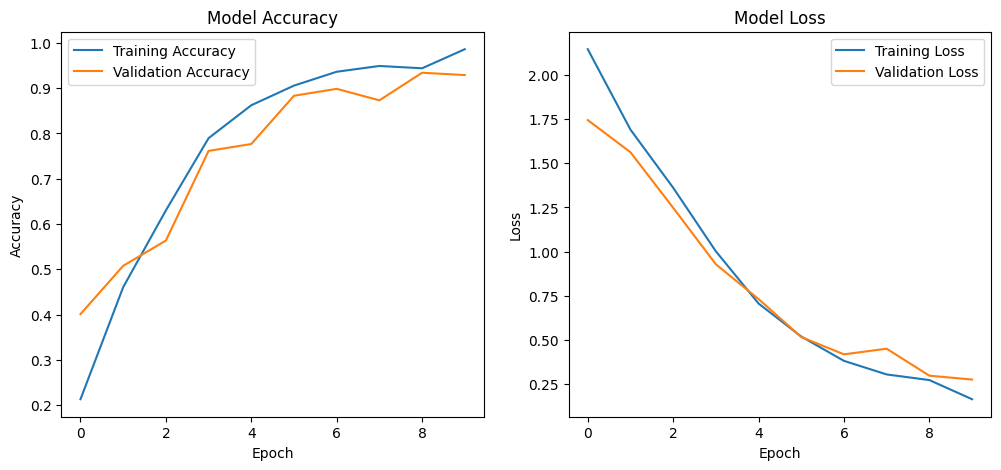

In [4]:
import os
import random
import numpy as np
from collections import Counter
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf.get_logger().setLevel('ERROR')

# Set seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

# Define the path to the dataset folder
dataset_folder = r'C:\Users\student\Downloads\ck_dataset'

# Function to load images and extract labels
def load_images_and_labels(base_folder):
    images = []
    labels = []
    for label_folder in os.listdir(base_folder):
        label_path = os.path.join(base_folder, label_folder)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                if filename.endswith('.png'):
                    image_file = os.path.join(label_path, filename)
                    img = Image.open(image_file).convert('L')  # Convert to grayscale
                    img = img.resize((64, 64))  # Resize to 64x64 for consistency
                    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
                    images.append(img_array)
                    labels.append(label_folder)  # The folder name is the label
    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)  # Reshape for CNN input

# Check for class imbalance
label_counts = Counter(labels)
print("Label distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count} images")

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_encoded),
    y=labels_encoded
)
class_weights_dict = dict(enumerate(class_weights))

# Define the CNN architecture function
def create_model():
    model = Sequential([
        InputLayer(input_shape=(64, 64, 1)),  # Input layer for 64x64 grayscale images
        Conv2D(32, kernel_size=(3, 3), activation='relu'),  # First convolution layer
        MaxPooling2D(pool_size=(2, 2)),  # First pooling layer
        # Conv2D(64, kernel_size=(3, 3), activation='relu'),  # Second convolution layer
        # MaxPooling2D(pool_size=(2, 2)),  # Second pooling layer
        Flatten(),  # Flatten the output for the dense layer
        Dense(100, activation='relu'),  # Fully connected layer
        Dense(len(np.unique(labels_encoded)), activation='softmax')  # Output layer with one neuron per class
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize list to store results
results = []

# No data augmentation configuration
config = {
    "shear_range": 0.0,
    "zoom_range": 0.0,
    "rotation_range": 0,
    "width_shift_range": 0.0,
    "height_shift_range": 0.0,
    "horizontal_flip": False
}

print(f"Running configuration: No Data Augmentation")

# Create the model
model = create_model()

# Define data augmentation configuration (with no augmentation)
datagen = ImageDataGenerator(
    shear_range=config["shear_range"],
    zoom_range=config["zoom_range"],
    rotation_range=config["rotation_range"],
    width_shift_range=config["width_shift_range"],
    height_shift_range=config["height_shift_range"],
    horizontal_flip=config["horizontal_flip"]
)

# Fit the data generator to the training data
datagen.fit(X_train)

# Train the model using class weights and the data generator
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32, seed=42),
    validation_data=(X_test, y_test),
    epochs=10,
    class_weight=class_weights_dict,
    verbose=0  # Suppress epoch prints
)

# Evaluate the model and store the results
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
predictions = model.predict(X_test, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

precision = tf.keras.metrics.Precision()
precision.update_state(true_classes, predicted_classes)
recall = tf.keras.metrics.Recall()
recall.update_state(true_classes, predicted_classes)
f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy())

# Store the configuration and results
config_results = {
    'config': 'No Data Augmentation',
    'test_accuracy': test_acc,
    'precision': precision.result().numpy(),
    'recall': recall.result().numpy(),
    'f1_score': f1_score
}

# Print the results for this configuration
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Precision: {precision.result().numpy():.2f}")
print(f"Recall: {recall.result().numpy():.2f}")
print(f"F1 Score: {f1_score:.2f}")
print("="*50)

results.append(config_results)

print("\nSummary of Results:")
for idx, result in enumerate(results):
    print(f"Configuration {idx+1}: {result['config']}")
    print(f"Test Accuracy: {result['test_accuracy']*100:.2f}%")
    print(f"Precision: {result['precision']:.2f}")
    print(f"Recall: {result['recall']:.2f}")
    print(f"F1 Score: {result['f1_score']:.2f}")
    print("="*50)

# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Label distribution:
anger: 135 images
contempt: 54 images
disgust: 177 images
fear: 75 images
happy: 207 images
sadness: 84 images
surprise: 249 images
Running configuration 1/64
Configuration 1/64: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 92.89%
Precision: 0.99
Recall: 0.97
F1 Score: 0.98
Running configuration 2/64
Configuration 2/64: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': True}
Test Accuracy: 95.43%
Precision: 1.00
Recall: 0.99
F1 Score: 0.99
Running configuration 3/64
Configuration 3/64: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.1, 'horizontal_flip': False}
Test Accuracy: 88.83%
Precision: 1.00
Recall: 0.91
F1 Score: 0.95
Running configuration 4/64
Configuration 4/64: {'shear_range': 0.0, 'zoom_range': 0.0, 'ro

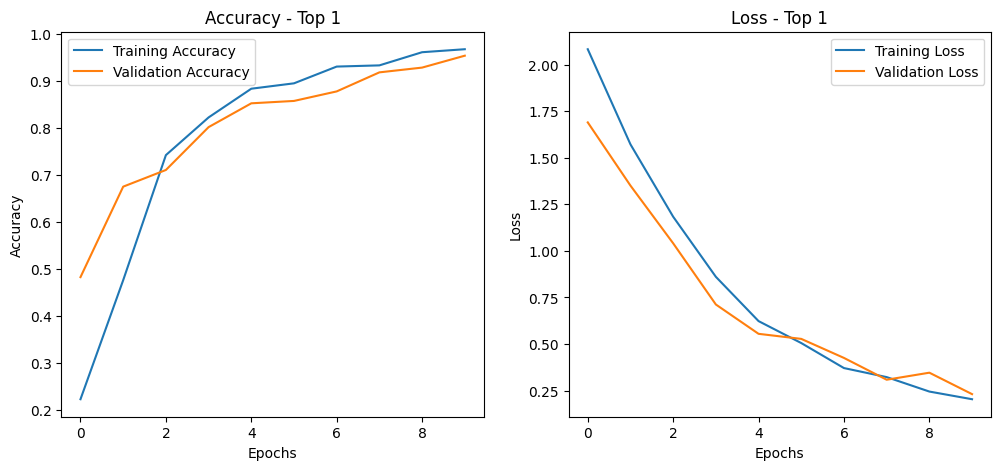

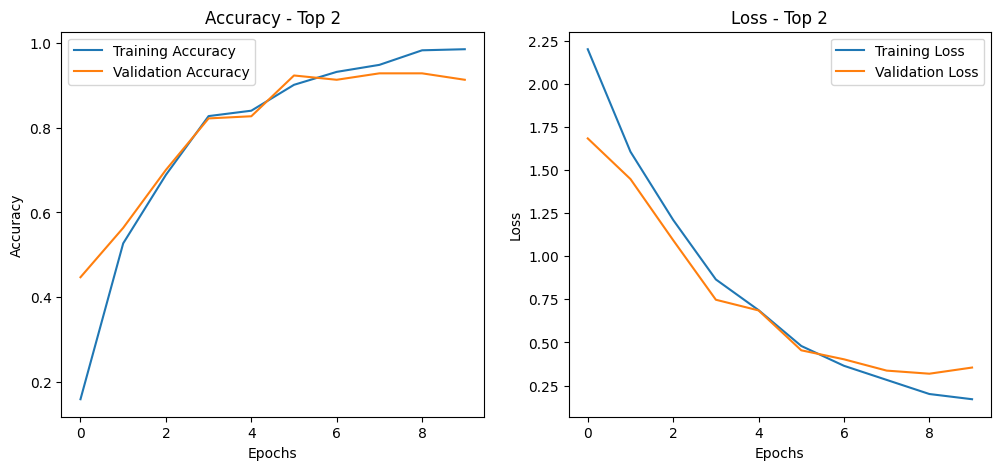

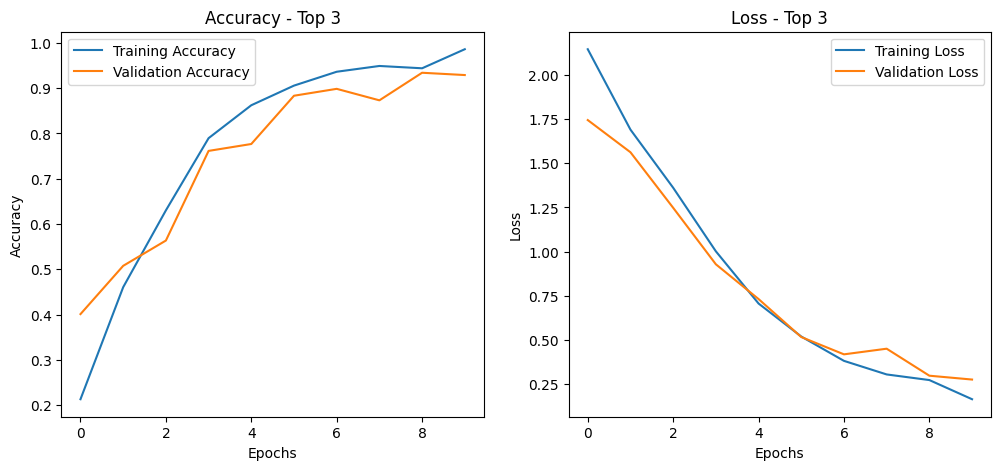

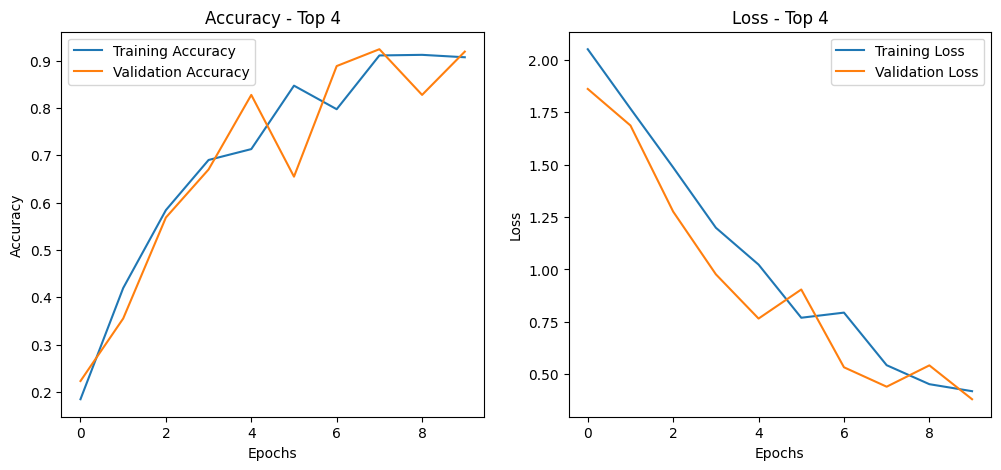

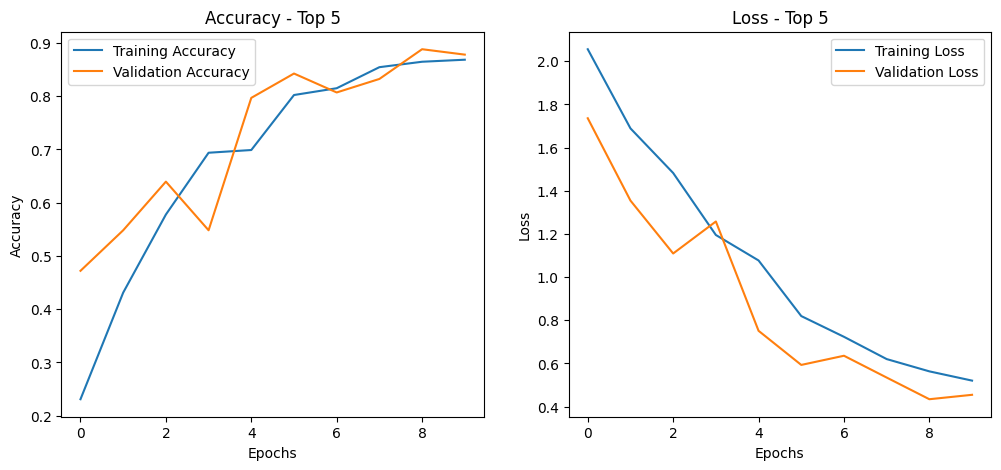

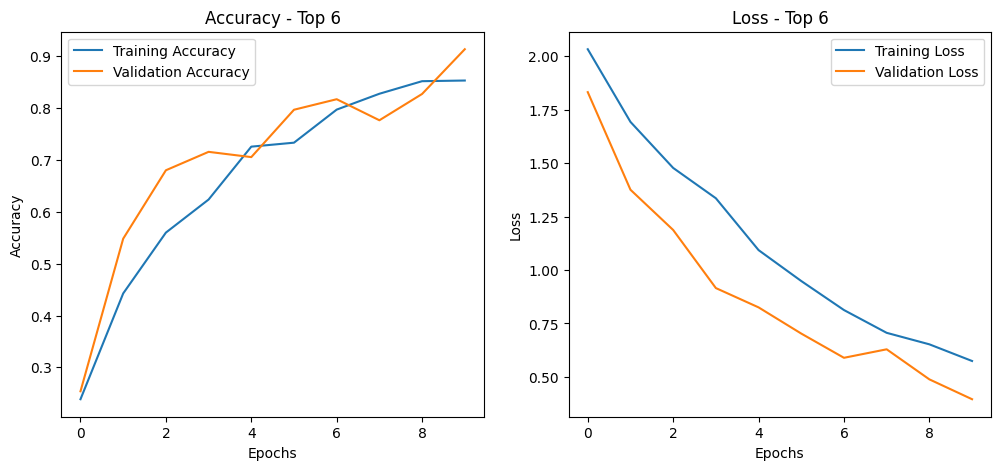

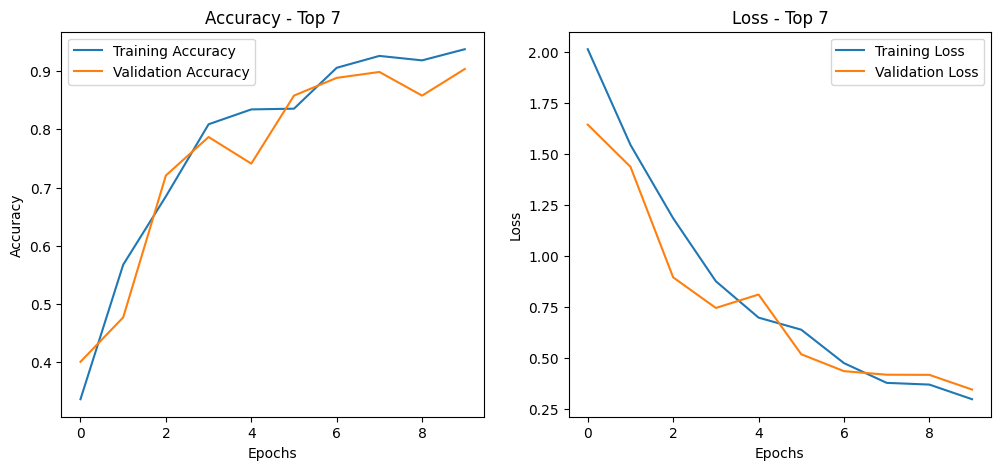

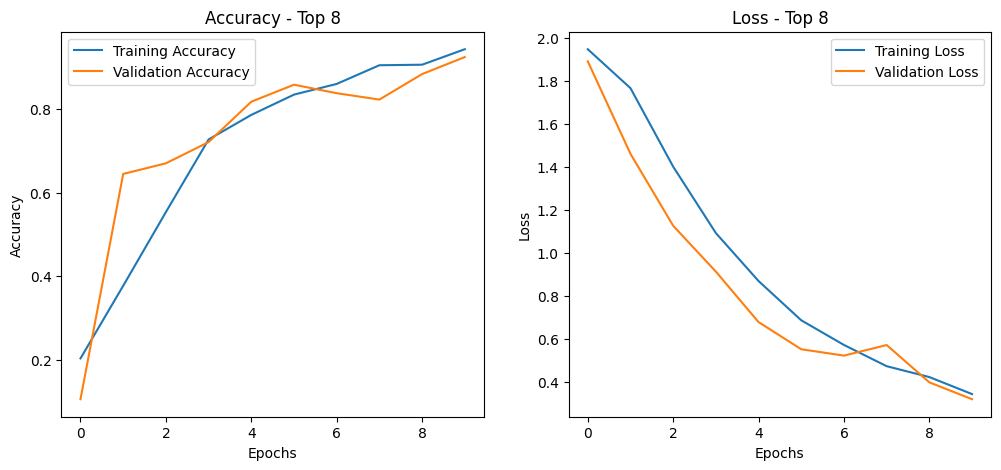

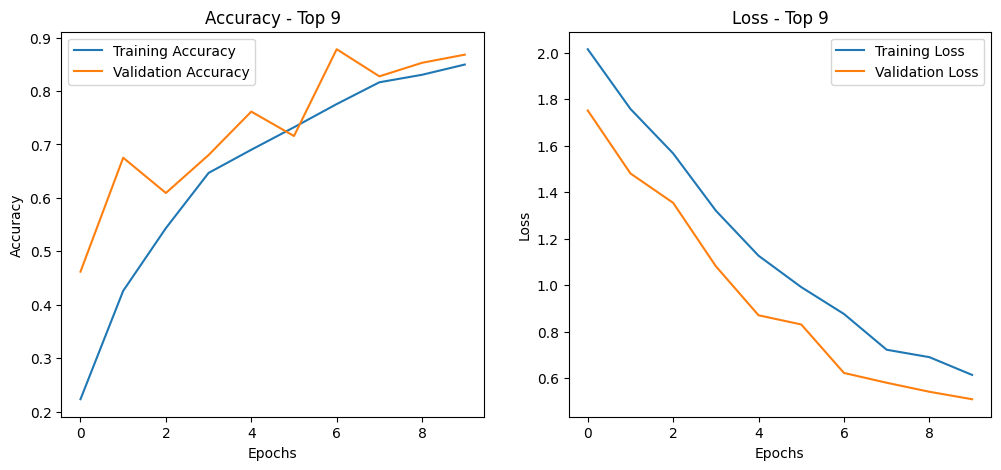

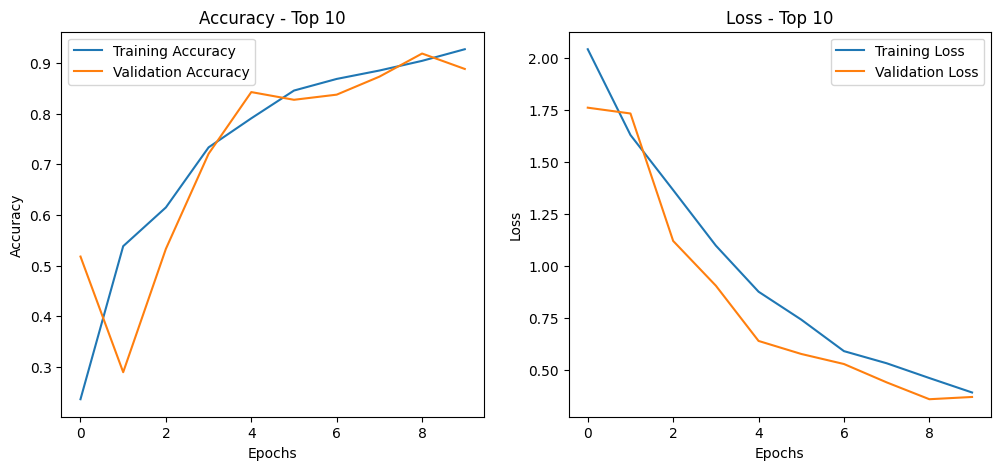

In [6]:
import os
import random
import numpy as np
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from itertools import product
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf.get_logger().setLevel('ERROR')

# Set seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

# Define the path to the CK dataset folder
dataset_folder = r'C:\Users\student\Downloads\ck_dataset'

# Function to load images and extract labels
def load_images_and_labels(base_folder):
    images = []
    labels = []
    for label_folder in os.listdir(base_folder):
        label_path = os.path.join(base_folder, label_folder)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                if filename.endswith('.png'):
                    image_file = os.path.join(label_path, filename)
                    img = Image.open(image_file).convert('L')  # Convert to grayscale
                    img = img.resize((64, 64))  # Resize to 64x64 for consistency
                    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
                    images.append(img_array)
                    labels.append(label_folder)  # The folder name is the label
    return np.array(images), np.array(labels)

# Function to define different augmentation combinations
# Function to define different augmentation combinations
def get_augmentation_combinations():
    shear_ranges = [0.0, 0.2]
    zoom_ranges = [0.0, 0.2]
    rotation_ranges = [0, 15]
    width_shift_ranges = [0.0, 0.1]
    height_shift_ranges = [0.0, 0.1]
    horizontal_flip_options = [False,True]
    combinations = list(product(shear_ranges, zoom_ranges, rotation_ranges,
                                width_shift_ranges, height_shift_ranges, horizontal_flip_options))

    return combinations


# Load images and labels
images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)  # Reshape for CNN input

# Check for class imbalance
label_counts = Counter(labels)
print("Label distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count} images")

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_encoded),
    y=labels_encoded
)
class_weights_dict = dict(enumerate(class_weights))

# Get augmentation combinations
augmentation_combinations = get_augmentation_combinations()

# Initialize list to store results
results = []

# Loop over all combinations
for idx, (shear, zoom, rotation, width_shift, height_shift, h_flip) in enumerate(augmentation_combinations):
    print(f"Running configuration {idx+1}/{len(augmentation_combinations)}")

    # Define the CNN architecture
    model = Sequential([
        InputLayer(input_shape=(64, 64, 1)),  # Input layer for 64x64 grayscale images
        Conv2D(32, kernel_size=(3, 3), activation='relu'),  # First convolution layer
        MaxPooling2D(pool_size=(2, 2)),  # First pooling layer
        Flatten(),  # Flatten the output for the dense layer
        Dense(100, activation='relu'),  # Fully connected layer
        Dense(len(np.unique(labels_encoded)), activation='softmax')  # Output layer with one neuron per class
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Define data augmentation configuration
    datagen = ImageDataGenerator(
        shear_range=shear,
        zoom_range=zoom,
        rotation_range=rotation,
        width_shift_range=width_shift,
        height_shift_range=height_shift,
        horizontal_flip=h_flip
    )

    # Fit the data generator to the training data
    datagen.fit(X_train)

    # Train the model using class weights and augmented data
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=32, seed=42),
        validation_data=(X_test, y_test),
        epochs=10,
        class_weight=class_weights_dict,
        verbose=0  # Suppress epoch prints
    )

    # Evaluate the model and store the results
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    predictions = model.predict(X_test, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)

    precision = tf.keras.metrics.Precision()
    precision.update_state(true_classes, predicted_classes)
    recall = tf.keras.metrics.Recall()
    recall.update_state(true_classes, predicted_classes)
    f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy())

    # Store the configuration and results
    config_results = {
        'config': {
            'shear_range': shear,
            'zoom_range': zoom,
            'rotation_range': rotation,
            'width_shift_range': width_shift,
            'height_shift_range': height_shift,
            'horizontal_flip': h_flip
        },
        'test_accuracy': test_acc,
        'precision': precision.result().numpy(),
        'recall': recall.result().numpy(),
        'f1_score': f1_score,
        'history': history.history  # Save training history for later plotting
    }

    # Print the results for this configuration
    print(f"Configuration {idx+1}/{len(augmentation_combinations)}: {config_results['config']}")
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Precision: {precision.result().numpy():.2f}")
    print(f"Recall: {recall.result().numpy():.2f}")
    print(f"F1 Score: {f1_score:.2f}")
    print("="*50)

    results.append(config_results)

# Sort results by F1 score to find the top 10 configurations
sorted_results = sorted(results, key=lambda x: x['f1_score'], reverse=True)[:10]

print("\nTop 10 Augmentation Configurations:")
for idx, result in enumerate(sorted_results):
    print(f"Rank {idx+1}: {result['config']}")
    print(f"Test Accuracy: {result['test_accuracy']*100:.2f}%")
    print(f"Precision: {result['precision']:.2f}")
    print(f"Recall: {result['recall']:.2f}")
    print(f"F1 Score: {result['f1_score']:.2f}")
    print("="*50)

# Plot the accuracy and loss for the top 10 configurations
for idx, result in enumerate(sorted_results):
    history = result['history']
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy - Top {idx+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Loss - Top {idx+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


Running configuration 1/16
{'config': {'conv_layers': 1, 'filters': 32, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.2, 'epochs': 30, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}, 'test_accuracy': 0.9847715497016907, 'precision': 1.0, 'recall': 0.99425286, 'f1_score': 0.997118119271402, 'history': <keras.src.callbacks.History object at 0x000001B6A739A760>}
Running configuration 2/16
{'config': {'conv_layers': 1, 'filters': 32, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.2, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}, 'test_accuracy': 0.9543147087097168, 'precision': 0.9942857, 'recall': 1.0, 'f1_score': 0.9971346646637115, 'history': <keras.src.callbacks.History object at 0x000001B6A70E2EE0>}
Running configuration 3/16
{'config': {'conv_layers': 1, 'filters': 32, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.2, 'epochs': 30, 'batch_size': 32, 'learning_rate': 0.001, 'activa

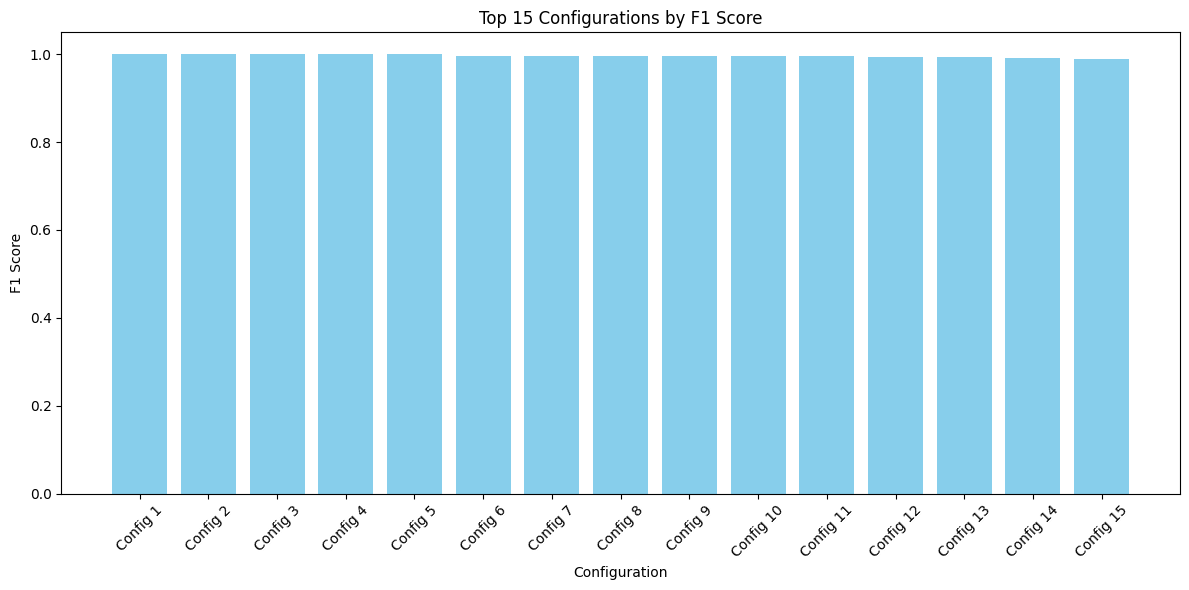

Top 1 Configuration:
Config Details: {'conv_layers': 1, 'filters': 64, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.2, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Test Accuracy: 0.9898, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000

Top 2 Configuration:
Config Details: {'conv_layers': 2, 'filters': 32, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.2, 'epochs': 30, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Test Accuracy: 0.9848, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000

Top 3 Configuration:
Config Details: {'conv_layers': 2, 'filters': 32, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.2, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Test Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000

Top 4 Configuration:
Config Details: {'conv_layers': 2, 'filters': 64, 'dense_layers': 1, 'dense_un

In [8]:
import os
import random
import numpy as np
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from itertools import product
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf.get_logger().setLevel('ERROR')

# Set seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

# Define the path to the CK+ dataset folder
dataset_folder = r'C:\Users\student\Downloads\ck_dataset'

# Function to load images and extract labels
def load_images_and_labels(base_folder):
    images = []
    labels = []
    for label_folder in os.listdir(base_folder):
        label_path = os.path.join(base_folder, label_folder)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg'):
                    image_file = os.path.join(label_path, filename)
                    img = Image.open(image_file).convert('L')  # Convert to grayscale
                    img = img.resize((64, 64))  # Resize to 64x64 for consistency
                    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
                    images.append(img_array)
                    labels.append(label_folder)  # The folder name is the label
    return np.array(images), np.array(labels)

# Load images and labels
try:
    images, labels = load_images_and_labels(dataset_folder)
    images = images.reshape(-1, 64, 64, 1)  # Reshape for CNN input
except Exception as e:
    print(f"Error loading images: {e}")

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)


# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_encoded),
    y=labels_encoded
)
class_weights_dict = dict(enumerate(class_weights))

# Data augmentation generator
data_gen = ImageDataGenerator(
    shear_range=0.0,
    zoom_range=0.0,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    horizontal_flip=True
)

parameter_combinations = list(product(
    [1, 2],           # conv_layers: Try 1 or 2 convolutional layers.
    [32, 64],         # filters: Use either 32 or 64 filters.
    [1],              # dense_layers: Stick with 1 dense layer for simplicity.
    [64, 128],        # dense_units: Test 64 or 128 units in the dense layer.
    [0.2],            # dropout: Use a fixed dropout rate of 0.2.
    [30, 50],         # epochs: Experiment with 30 or 50 epochs.
    [32],             # batch_size: Use a batch size of 32.
    [0.001],          # learning_rate: Use a fixed learning rate of 0.001.
    ['relu'],         # activation: Use ReLU activation.
    ['adam']          # optimizer: Use the Adam optimizer.
))

# Loop over configurations
config_results = []

for idx, (conv_layers, filters, dense_layers, dense_units, dropout, epochs, batch_size, learning_rate, activation, optimizer) in enumerate(parameter_combinations):
    try:
        print(f"Running configuration {idx+1}/{len(parameter_combinations)}")
        model = Sequential()
        model.add(InputLayer(input_shape=(64, 64, 1)))
        for _ in range(conv_layers):
            model.add(Conv2D(filters, kernel_size=(3, 3), activation=activation))
            model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        for _ in range(dense_layers):
            model.add(Dense(dense_units, activation=activation))
            model.add(Dropout(dropout))
        model.add(Dense(len(np.unique(labels_encoded)), activation='softmax'))

        if optimizer == 'adam':
            optimizer_instance = Adam(learning_rate=learning_rate)
        else:
            optimizer_instance = SGD(learning_rate=learning_rate)
        model.compile(optimizer=optimizer_instance, loss='categorical_crossentropy', metrics=['accuracy'])

        # Train with data augmentation
        train_gen = data_gen.flow(X_train, y_train, batch_size=batch_size)
        history = model.fit(train_gen, epochs=epochs, validation_data=(X_test, y_test), class_weight=class_weights_dict, verbose=0)

        # Evaluate
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
        predictions = model.predict(X_test, verbose=0)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(y_test, axis=1)

        precision = tf.keras.metrics.Precision()
        precision.update_state(true_classes, predicted_classes)
        recall = tf.keras.metrics.Recall()
        recall.update_state(true_classes, predicted_classes)
        f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy())

        config_results.append({
            'config': {
                'conv_layers': conv_layers,
                'filters': filters,
                'dense_layers': dense_layers,
                'dense_units': dense_units,
                'dropout': dropout,
                'epochs': epochs,
                'batch_size': batch_size,
                'learning_rate': learning_rate,
                'activation': activation,
                'optimizer': optimizer
            },
            'test_accuracy': test_acc,
            'precision': precision.result().numpy(),
            'recall': recall.result().numpy(),
            'f1_score': f1_score,
            'history': history
        })

        # Print current configuration results
        print(config_results[-1])
    except Exception as e:
        print(f"Failed to run configuration {idx+1} due to: {e}")

# Sort the results based on F1-score in descending order
sorted_results = sorted(config_results, key=lambda x: x['f1_score'], reverse=True)

# Get the top 15 configurations
top_15_configs = sorted_results[:15]

# Extracting details for plotting
f1_scores = [result['f1_score'] for result in top_15_configs]
config_labels = [f"Config {i+1}" for i in range(15)]

# Plotting the top 15 configurations based on F1 score
plt.figure(figsize=(12, 6))
plt.bar(config_labels, f1_scores, color='skyblue')
plt.xlabel('Configuration')
plt.ylabel('F1 Score')
plt.title('Top 15 Configurations by F1 Score')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.show()

# Optionally, print out details of the top 15 configurations
for idx, result in enumerate(top_15_configs):
    config_details = result['config']
    print(f"Top {idx+1} Configuration:")
    print(f"Config Details: {config_details}")
    print(f"Test Accuracy: {result['test_accuracy']:.4f}, Precision: {result['precision']:.4f}, Recall: {result['recall']:.4f}, F1 Score: {result['f1_score']:.4f}\n")


Training Configuration 1: {'conv_layers': 1, 'filters': 64, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.2, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}


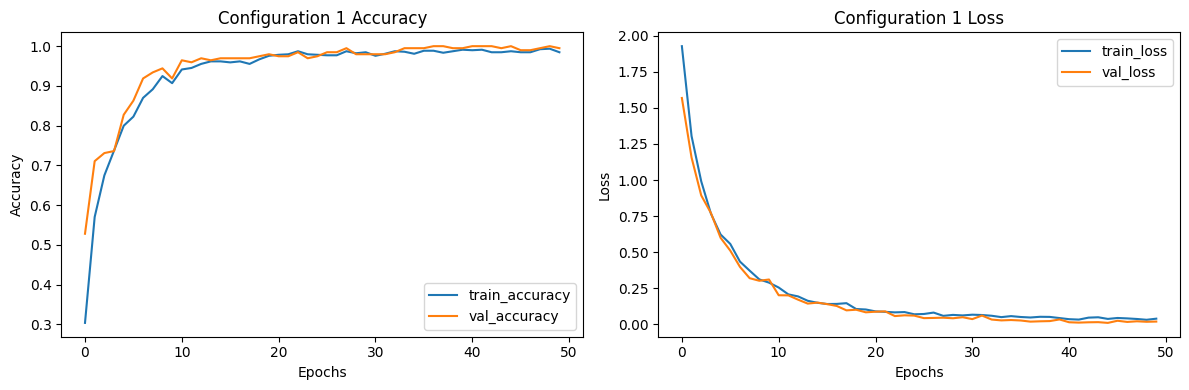

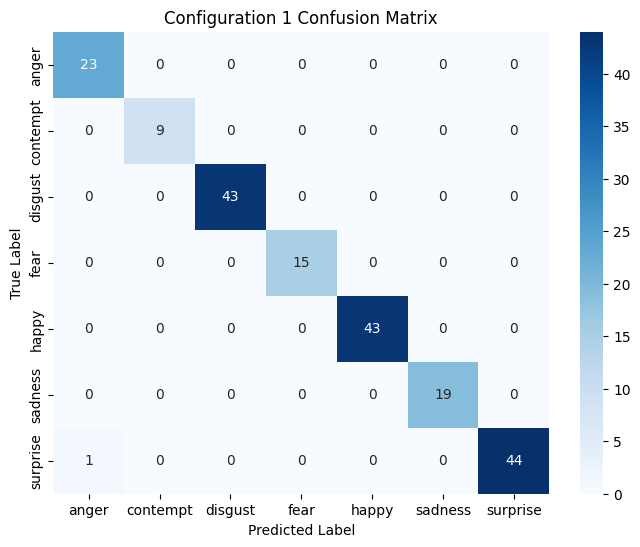

Test Accuracy: 0.9949
Test Loss: 0.0190
Training Configuration 2: {'conv_layers': 2, 'filters': 32, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.2, 'epochs': 30, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}


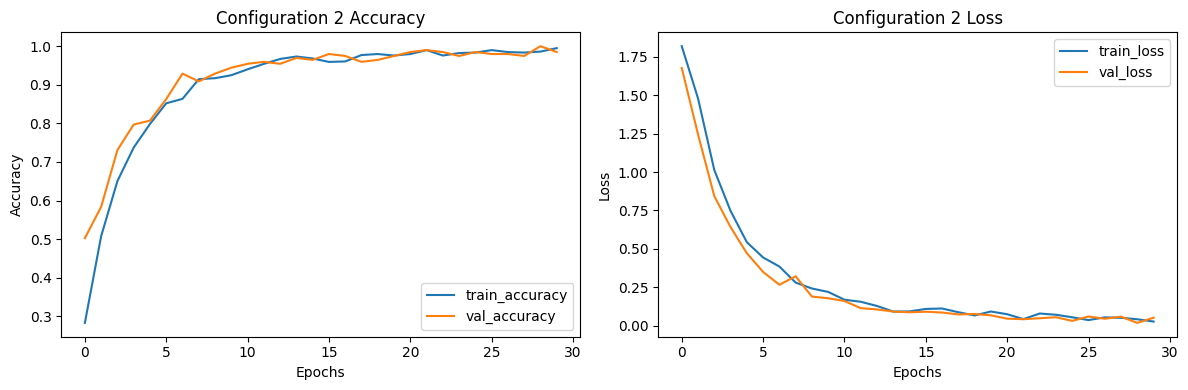

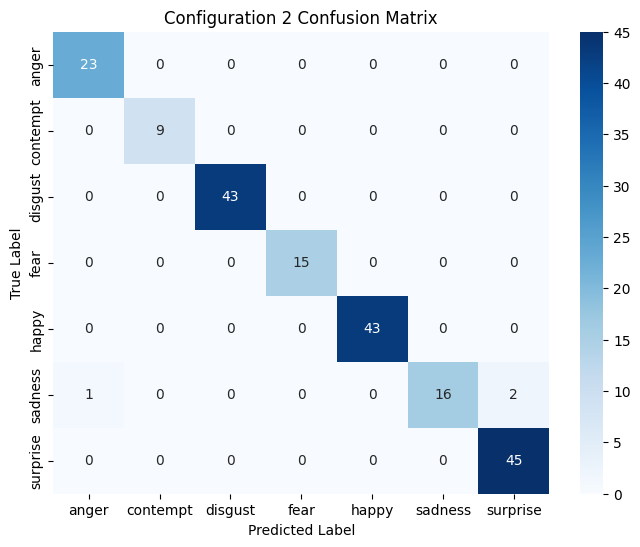

Test Accuracy: 0.9848
Test Loss: 0.0524
Training Configuration 3: {'conv_layers': 2, 'filters': 32, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.2, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}


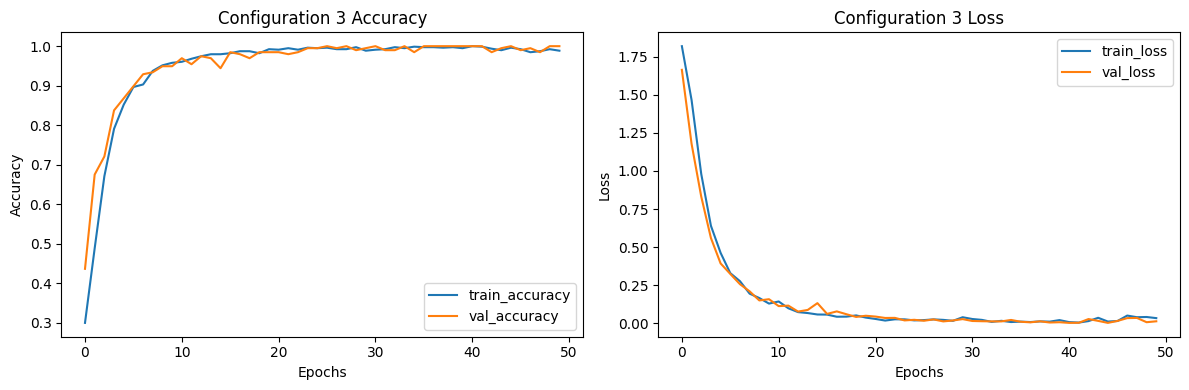

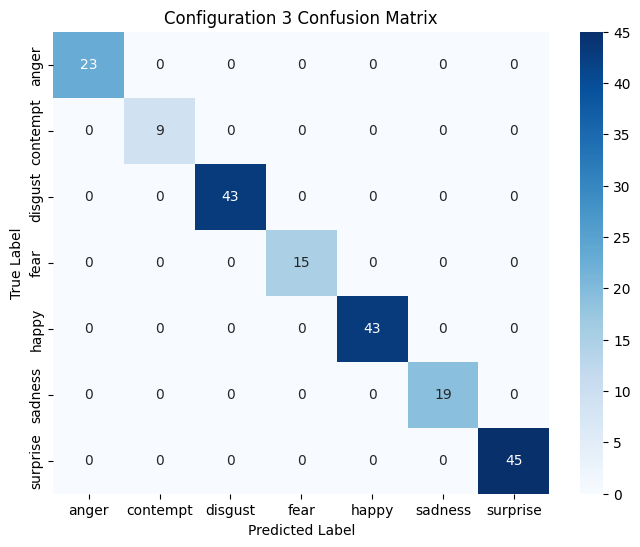

Test Accuracy: 1.0000
Test Loss: 0.0143
Training Configuration 4: {'conv_layers': 2, 'filters': 64, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.2, 'epochs': 30, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}


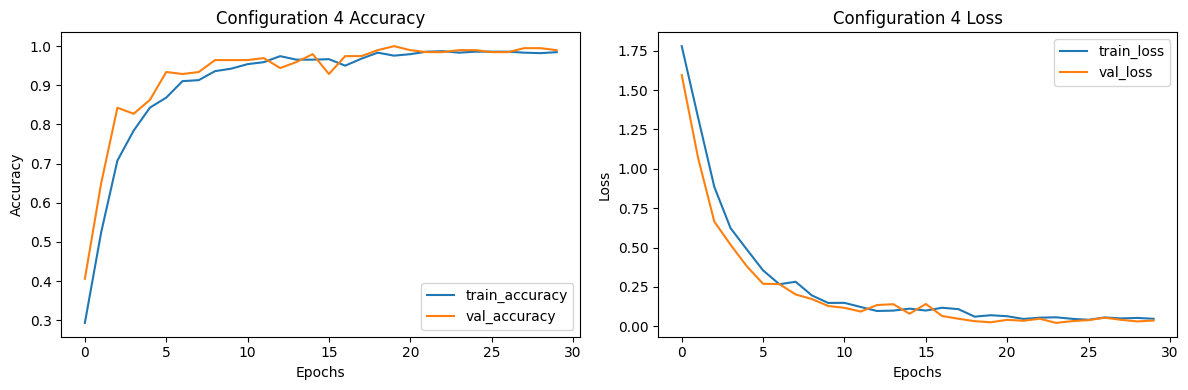

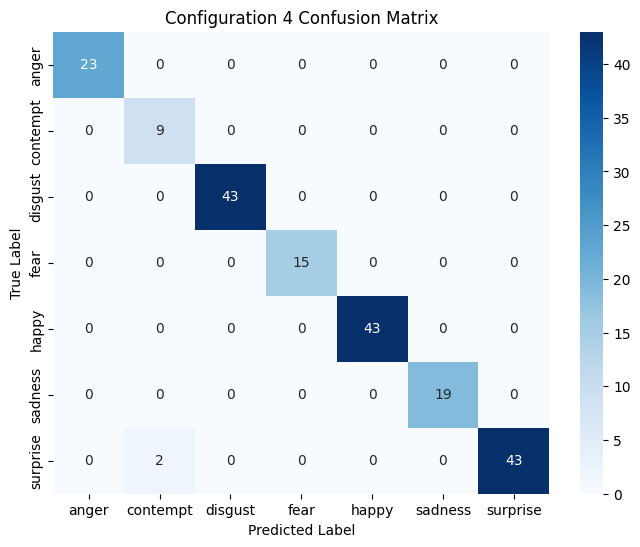

Test Accuracy: 0.9898
Test Loss: 0.0365
Training Configuration 5: {'conv_layers': 2, 'filters': 64, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.2, 'epochs': 30, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}


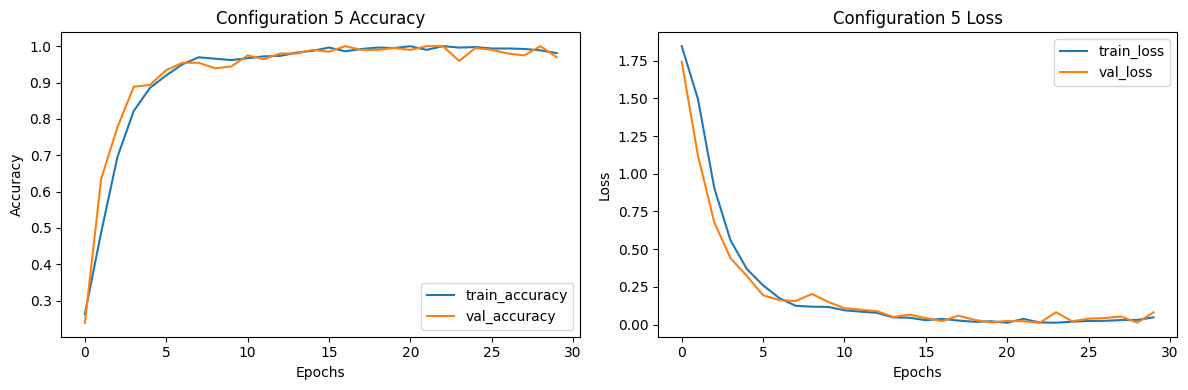

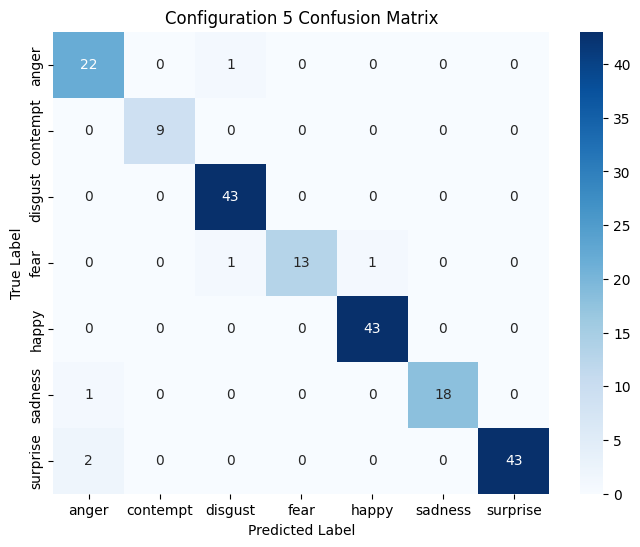

Test Accuracy: 0.9695
Test Loss: 0.0819


In [11]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf.get_logger().setLevel('ERROR')

# Set seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

# Define the path to the CK+ dataset folder
dataset_folder = r'C:\Users\student\Downloads\ck_dataset'

# Function to load images and extract labels
def load_images_and_labels(base_folder):
    images = []
    labels = []
    for label_folder in os.listdir(base_folder):
        label_path = os.path.join(base_folder, label_folder)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg'):
                    image_file = os.path.join(label_path, filename)
                    img = Image.open(image_file).convert('L')  # Convert to grayscale
                    img = img.resize((64, 64))  # Resize to 64x64 for consistency
                    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
                    images.append(img_array)
                    labels.append(label_folder)  # The folder name is the label
    return np.array(images), np.array(labels)

# Load images and labels
try:
    images, labels = load_images_and_labels(dataset_folder)
    images = images.reshape(-1, 64, 64, 1)  # Reshape for CNN input
except Exception as e:
    print(f"Error loading images: {e}")

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Data augmentation generator
data_gen = ImageDataGenerator(
    shear_range=0.0,
    zoom_range=0.0,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    horizontal_flip=True
)

# Top configurations from your list
configurations = [
    {'conv_layers': 1, 'filters': 64, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.2, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'},
    {'conv_layers': 2, 'filters': 32, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.2, 'epochs': 30, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'},
    {'conv_layers': 2, 'filters': 32, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.2, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'},
    {'conv_layers': 2, 'filters': 64, 'dense_layers': 1, 'dense_units': 64, 'dropout': 0.2, 'epochs': 30, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'},
    {'conv_layers': 2, 'filters': 64, 'dense_layers': 1, 'dense_units': 128, 'dropout': 0.2, 'epochs': 30, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
]

from sklearn.metrics import precision_score, recall_score, f1_score

# Train and evaluate each configuration
for idx, config in enumerate(configurations):
    print(f"Training Configuration {idx + 1}: {config}")
    
    # Model definition
    model = Sequential()
    model.add(InputLayer(input_shape=(64, 64, 1)))
    for _ in range(config['conv_layers']):
        model.add(Conv2D(config['filters'], kernel_size=(3, 3), activation=config['activation']))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    for _ in range(config['dense_layers']):
        model.add(Dense(config['dense_units'], activation=config['activation']))
        model.add(Dropout(config['dropout']))
    model.add(Dense(len(np.unique(labels_encoded)), activation='softmax'))

    optimizer_instance = Adam(learning_rate=config['learning_rate'])
    model.compile(optimizer=optimizer_instance, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train with data augmentation
    train_gen = data_gen.flow(X_train, y_train, batch_size=config['batch_size'])
    history = model.fit(train_gen, epochs=config['epochs'], validation_data=(X_test, y_test), verbose=0)

    # Evaluate the model
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    predictions = model.predict(X_test, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)

    # Calculate additional metrics
    precision = precision_score(true_classes, predicted_classes, average='weighted')
    recall = recall_score(true_classes, predicted_classes, average='weighted')
    f1 = f1_score(true_classes, predicted_classes, average='weighted')

    # Plot accuracy and loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(f'Configuration {idx + 1} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'Configuration {idx + 1} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Configuration {idx + 1} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Print metrics
    print(f"Test Accuracy: {test_acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
